In [1]:
# Import necessary modules

import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

import spacy
from spacy import displacy
from spacy.util import minibatch, compounding

from nltk.tokenize import WordPunctTokenizer
import re
from bs4 import BeautifulSoup

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Display 100 characters max within a cell
pd.set_option('max_colwidth',200)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Administrator/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/Administrator/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/Administrator/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Read data
df = pd.read_csv('text_emotion.csv')

## Data Understanding and Preprocessing

In [3]:
df.head(10)

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will."
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!"
7,1956968636,worry,mcsleazy,Hmmm. http://www.djhero.com/ is down
8,1956969035,sadness,nic0lepaula,@charviray Charlene my love. I miss you
9,1956969172,sadness,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?


It looks like there are lots of different characters, creative spelling and punctuation, misspellings, slang, new words or URLs. This needs to be fixed

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
tweet_id     40000 non-null int64
sentiment    40000 non-null object
author       40000 non-null object
content      40000 non-null object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


There are no empty rows, no need to fill/delete NAN values

In [5]:

# Print the count and the ratio of the emotions
pd.DataFrame([df.sentiment.value_counts(), df.sentiment.value_counts(normalize=True)]).T

,sentiment,sentiment
neutral,8638.0,0.215950
worry,8459.0,0.211475
happiness,5209.0,0.130225
sadness,5165.0,0.129125
love,3842.0,0.096050
surprise,2187.0,0.054675
fun,1776.0,0.044400
relief,1526.0,0.038150
hate,1323.0,0.033075
empty,827.0,0.020675


Lets see the group of sentiments on a graph

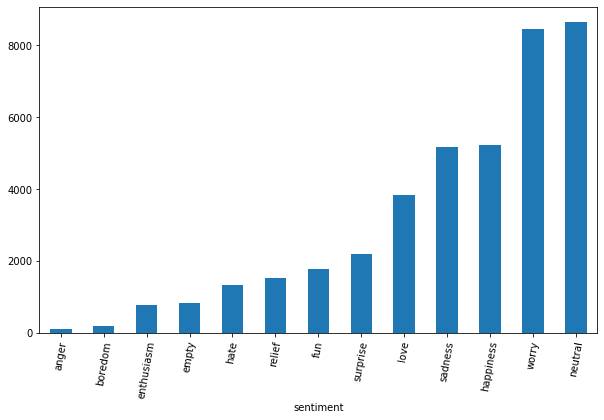

In [6]:
plt.subplots(figsize=(10,6))

df.groupby('sentiment')['content'].count().sort_values(ascending=True).plot(kind='bar')
plt.xticks(rotation=80)
plt.show()

In [7]:
df.describe(include='object')

,sentiment,author,content
count,40000,40000,40000
unique,13,33871,39827
top,neutral,MissxMarisa,I just received a mothers day card from my lovely daughter wishing my a happy mothers day http://tr.im/kWK9
freq,8638,23,14


In [8]:
df.isnull().sum()

tweet_id     0
sentiment    0
author       0
content      0
dtype: int64

No missing values

In [9]:
df.content.duplicated().sum()

173

It looks like there are duplicated tweets (which could be retweets maybe) that needs to be taken into consideration

In [10]:
df.content.value_counts()[df.content.value_counts()>1]

I just received a mothers day card from my lovely daughter wishing my a happy mothers day  http://tr.im/kWK9    14
FREE UNLIMITED RINGTONES!!! - http://tinyurl.com/freeringring - USA ONLY - Awesome 4 iphone                     13
Happy Mothers Day                                                                                               10
Happy Mother's Day!                                                                                             10
happy mother's day                                                                                               8
                                                                                                                ..
Good morning!                                                                                                    2
happy mothers day!                                                                                               2
i wanna go home                                                                 

In [11]:
df[df.content=='happy mothers day']

,tweet_id,sentiment,author,content
29348,1751177832,love,jadeeisabel,happy mothers day
36768,1753366853,love,janethglz,happy mothers day
36819,1753381594,happiness,bree_gee,happy mothers day
37340,1753468050,love,starbuckscup,happy mothers day
39131,1753773088,neutral,vwebling,happy mothers day


For the same tweet there are different sentiments in the sentiment column. I decided to drop these duplicates and different labels

In [12]:
df=df.drop_duplicates(subset='content')

In [13]:
df.content.duplicated().sum()

0

Now lets see the distribution of emotions in the data set

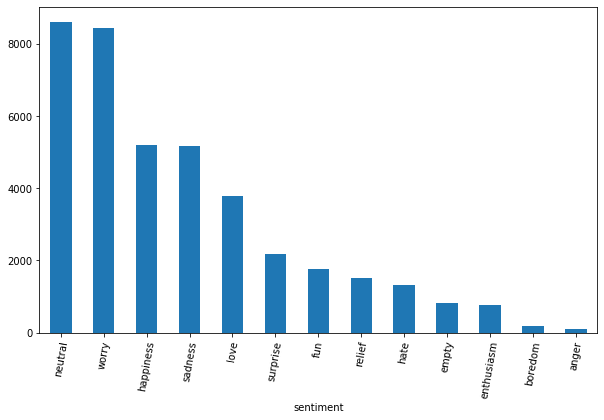

In [14]:
plt.subplots(figsize=(10,6))

df.groupby('sentiment')['content'].count().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=80)
plt.show()

The emotion 'empty' looks different, lets see what is empty 

In [15]:
df[df.sentiment == 'empty'].sample(10)

,tweet_id,sentiment,author,content
25411,1695083008,empty,CreepyMcWeirdo,Making a twitter account
23952,1694727107,empty,fadilnet,@Twinklybird Ace @ the exams!
16941,1965481334,empty,DeevasInc,@brian_jenkins nothing yet
14963,1964692432,empty,mistermeester,@dushbag And I totally wish I was going to Orlando. How long until you're there? I forget how long the drive is.
36953,1753400711,empty,lilsiss,so i guess we r sleepin over.
15783,1964982051,empty,supajulz,because it is too hot i am sleeping with the window open. just means all the noise will make me up early
1111,1957218864,empty,pachieshee,wants to go home.
15649,1964946076,empty,billyINT,Ugh. Kinda bored.
18353,1965947035,empty,jjbabyMEOWZER,I jus dropped my dog and im tall.
16742,1965436740,empty,VaN_EvItA,@tatiiiiv me too Tatiiiii!!!


There are different emotions that are categorized es 'empty', even though they should be 'bored', 'happy' or 'sad'. To deal with this, we could clean empty tweets

In [16]:
df=df[df.sentiment!='empty']
df.shape

(39005, 4)

### Cleaning the tweet texts

In [17]:
import string

# from autocorrect import speller

def tweet_cleaner(tweet):
    
    # To lowercase 
    tweet = tweet.lower()
    
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    
    #Convert @username to "@user"
    tweet = re.sub('@[^\s]+','@user',tweet)
    
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ')
    
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF')
    
    # Remove hyperlinks 
    tweet = re.sub(r'https?:\/\/.*\/\w*', 'http', tweet)
    
    # Remove tickers such as USD ($)
    tweet = re.sub(r'\$\w*', '', tweet)
    
    # Remove hashtags 
    tweet = re.sub(r'#\w*', '', tweet)
    
    # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet  = "".join([char for char in tweet if char not in string.punctuation])
    tweet = re.sub('[0-9]+', ' ', tweet)
    
#     # Spell correction

#     tweet = [speller(w) for w in (nltk.word_tokenize(tweet))]
#     tweet = " ".join(tweet)

    return tweet

In [18]:

df['Cleaned'] = df.content.apply(tweet_cleaner)
df.head(10)

,tweet_id,sentiment,author,content,Cleaned
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin n bed with a headache ughhhhwaitin on your call
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremonygloomy friday
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants to hang out with friends soon
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",user we want to trade with someone who has houston tickets but no one will
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,repinging user why didnt you go to prom bc my bf didnt like my friends
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!",i should be sleep but im not thinking about an old friend who i want but hes married now damn he wants me scandalous
7,1956968636,worry,mcsleazy,Hmmm. http://www.djhero.com/ is down,hmmm http is down
8,1956969035,sadness,nic0lepaula,@charviray Charlene my love. I miss you,user charlene my love i miss you
9,1956969172,sadness,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?,user im sorry at least its friday
10,1956969456,neutral,feinyheiny,cant fall asleep,cant fall asleep


### Removing the stopwords

In [19]:
stop = stopwords.words('english')
df['Cleaned'] = df['Cleaned'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
df.head(10)

,tweet_id,sentiment,author,content,Cleaned
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin n bed headache ughhhhwaitin call
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremonygloomy friday
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants hang friends soon
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",user want trade someone houston tickets one
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,repinging user didnt go prom bc bf didnt like friends
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!",sleep im thinking old friend want hes married damn wants scandalous
7,1956968636,worry,mcsleazy,Hmmm. http://www.djhero.com/ is down,hmmm http
8,1956969035,sadness,nic0lepaula,@charviray Charlene my love. I miss you,user charlene love miss
9,1956969172,sadness,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?,user im sorry least friday
10,1956969456,neutral,feinyheiny,cant fall asleep,cant fall asleep


### Let's apply a common words filter for removing most common words 

In [20]:
import pickle

MIN_NUMBER_OF_SR = 500
MIN_COM_WORDS = 0.01
MIN_UNCOM_WORDS = 0.01
UNCOM_WORDS = 0.01
dataframe = df
pivot_feature = 'sentiment'
text_feature = 'Cleaned'

def common_word_filter (dataframe, pivot_feature, text_feature):
    
    NUM_OF_SUB_TECH = len(dataframe[pivot_feature].value_counts()[dataframe[pivot_feature].value_counts() > MIN_NUMBER_OF_SR].index.tolist())
    
    list_common = []
    
    list_uncommon =[]
    
    list_least_common = []
    
    for sub_tech in dataframe[pivot_feature].value_counts()[dataframe[pivot_feature].value_counts() > MIN_NUMBER_OF_SR].index.tolist():
        
        cleaned_text = [str(txt) for text in dataframe[dataframe[pivot_feature] == sub_tech][text_feature] for txt in text.split(' ') if len(txt) > 2 and txt not in ' ']
        
        word_dist = nltk.FreqDist(cleaned_text)
        
        list_common.append([x[0] for x in word_dist.most_common(int(len(word_dist)*MIN_COM_WORDS))])
        
        list_uncommon.append([x[0] for x in word_dist.most_common(len(word_dist))[-int(len(word_dist)*MIN_UNCOM_WORDS):]])
        
        list_least_common.append([x[0] for x in word_dist.most_common(len(word_dist))[-int(len(word_dist)*UNCOM_WORDS):]])
    
    list_common_fl = [x for y in list_common for x in y]
    
    list_uncommon_fl = [x for y in list_uncommon for x in y]
    
    word_dist_com = nltk.FreqDist(list_common_fl)
    
    word_dist_ucom = nltk.FreqDist(list_uncommon_fl)
    
    list_final_com = [x[0] for x in word_dist_com.most_common(len(list_common_fl)) if x[1] > NUM_OF_SUB_TECH*0.75]
    
    list_final_ucom = [x[0] for x in word_dist_ucom.most_common(len(list_uncommon_fl)) if x[1] < NUM_OF_SUB_TECH*0.25]
    
    final_list = list(set(list_final_com + list_final_ucom + [y for x in list_least_common for y in x]))
    
    with open('common_word_list_for_filtering.pickle', 'wb') as handle:
    
        pickle.dump(final_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return final_list



In [21]:
final_list = common_word_filter(df, 'sentiment','Cleaned')

In [22]:
len(final_list)

678

In [23]:
len(df.content)

39005

In [24]:
df['Cleaned'] = df['Cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (final_list)]))
df.head()

,tweet_id,sentiment,author,content,Cleaned
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin n bed headache ughhhhwaitin call
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremonygloomy friday
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants hang friends soon
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",trade someone houston tickets
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,repinging didnt go prom bc bf didnt friends


### Vectorizing the Data before applying models

### Count vectorizing

In [27]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(df['Cleaned'],
                                                    df['sentiment'],
                                                    test_size=.20, random_state=53)

In [28]:
count_vect1 = CountVectorizer(min_df=0.001)
count_vect_train1 = count_vect1.fit_transform(X_train1)
count_vect_train1 = count_vect_train1.toarray()
count_vect_test1 = count_vect1.transform(X_test1)
count_vect_test1 = count_vect_test1.toarray()

### Logistic Regression

In [29]:
logreg_CV1 = LogisticRegression(multi_class='multinomial', solver='newton-cg',class_weight='balanced',
                              C=1.0,n_jobs=-1, random_state=5)
logreg_CV1.fit(count_vect_train1, y_train1)
y_pred_lr_CV1 = logreg_CV1.predict(count_vect_test1)
print('Accuracy :', metrics.accuracy_score(y_test1, y_pred_lr_CV1))

Accuracy : 0.2208691193436739


Because of the feuture distribution of the sample, we were expecting a low accuracy in our model. In order to balance the distribution, we can update the categorization of the emotions.

We have 13 emotions and we can categorize them in 3 sentiment categories: positive, neutral and negative

anger, boredom, hate, worry, sadness: Negative

happiness, fun, love, surprise, enthusiasm, relief: Positive

empty, neutral : Neutral

In [33]:
# Create a new dataframe with new 3 sentiments
dfnew=df.copy()

In [34]:
dfnew.sentiment.replace(['anger','boredom','hate','worry','sadness','happiness','fun','love','surprise','enthusiasm','relief','empty','neutral'],
                    ['negative','negative','negative','negative','negative','positive','positive','positive','positive','positive','positive','neutral','neutral'],
                       inplace=True)

In [36]:
dfnew.head()

,tweet_id,sentiment,author,content,Cleaned
1,1956967666,negative,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin n bed headache ughhhhwaitin call
2,1956967696,negative,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremonygloomy friday
3,1956967789,positive,czareaquino,wants to hang out with friends SOON!,wants hang friends soon
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",trade someone houston tickets
5,1956968477,negative,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,repinging didnt go prom bc bf didnt friends


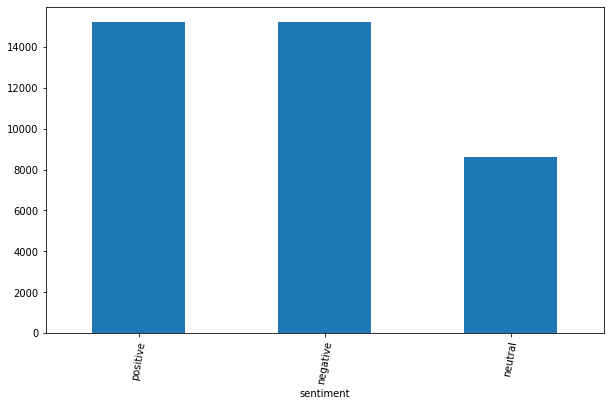

In [37]:
plt.subplots(figsize=(10,6))

dfnew.groupby('sentiment')['content'].count().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=80)
plt.show()

Because of the imbalance in the distribution and the low result in emotions data set, adding more labeled data could be helpful

In [38]:
dfadd = pd.read_csv('additionalclean.csv')

In [39]:
dfbig = pd.concat([dfnew, dfadd], ignore_index=True, sort =False)
dfbig.shape

(53432, 6)

In [41]:
dfbig.head()

,tweet_id,sentiment,author,content,Cleaned,Unnamed: 0
0,1.956968e+09,negative,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin n bed headache ughhhhwaitin call,NaN
1,1.956968e+09,negative,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremonygloomy friday,NaN
2,1.956968e+09,positive,czareaquino,wants to hang out with friends SOON!,wants hang friends soon,NaN
3,1.956968e+09,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",trade someone houston tickets,NaN
4,1.956968e+09,negative,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,repinging didnt go prom bc bf didnt friends,NaN


There is an extra column occured, needs to be dropped

In [42]:
dfbig = dfbig.drop(['Unnamed: 0'], axis=1)
dfnew=dfbig
dfnew.head()

,tweet_id,sentiment,author,content,Cleaned
0,1.956968e+09,negative,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin n bed headache ughhhhwaitin call
1,1.956968e+09,negative,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremonygloomy friday
2,1.956968e+09,positive,czareaquino,wants to hang out with friends SOON!,wants hang friends soon
3,1.956968e+09,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",trade someone houston tickets
4,1.956968e+09,negative,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,repinging didnt go prom bc bf didnt friends


Now we can re-train our new and clean data set 

## Train-Test Split

In [43]:

X_train, X_test, y_train, y_test = train_test_split(dfnew['Cleaned'],
                                                    dfnew['sentiment'],
                                                    test_size=.25, random_state=53)

## Count Vectirizing

In [45]:
count_vect = CountVectorizer(min_df=0.001)
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

In [46]:
vocab = count_vect.get_feature_names()

In [47]:
pd.DataFrame(count_vect_train, columns=vocab).head(10)

,10,11,12,15,1st,20,200,24,25,2nd,...,you,youll,your,youre,youtube,youve,yr,yum,yummy,ûï
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Logistic Regression

In [48]:

logreg_CV = LogisticRegression(random_state=0)
logreg_CV.fit(count_vect_train, y_train)
y_pred_lr_CV = logreg_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_lr_CV))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy : 0.6158856116185057


##  Linear SVC

In [49]:

Lsvc = LinearSVC()

Lsvc.fit(count_vect_train, y_train)

pred= Lsvc.predict(count_vect_test)

metrics.accuracy_score(y_test, pred)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.6156610270998653

## Naive Bayes

In [50]:

from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()

nb_classifier.fit(count_vect_train, y_train)

pred = nb_classifier.predict(count_vect_test)

metrics.accuracy_score(y_test, pred)

0.566701602036233

## Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier
rf_CV = RandomForestClassifier(random_state=0, n_jobs=-1, class_weight="balanced", n_estimators = 200)
rf_CV.fit(count_vect_train, y_train)
y_pred_rf_CV = rf_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_rf_CV))

Accuracy : 0.5810001497230124


## Tf-idf Vectorization¶

In [55]:
tfidf_vect = TfidfVectorizer(min_df=1, max_df=1.0, use_idf=True)
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_train = tfidf_vect_train.toarray()
tfidf_vect_test = tfidf_vect.transform(X_test)
vocab = tfidf_vect.get_feature_names()
pd.DataFrame(np.round(tfidf_vect_train, 2), columns=vocab).head(10)

print('Longest word:', max(tfidf_vect.vocabulary_, key=len))

Longest word: imwatchingthehannahmoviewithmomshesaidthisfilmverygreat


It looks like, the reason for not having spaces between words is the user, lets check some random text

In [56]:
dfnew.sample(10)

,tweet_id,sentiment,author,content,Cleaned
20901,1.694238e+09,positive,myfolklover,@FelineBred glad you like them,glad
23982,1.694879e+09,positive,lianalovesdelta,"we can sail around the world, you and me baby...",sail around world baby
47659,5.680150e+17,negative,681459731,@JetBlue why is t that every time I fly jfk even more speed doesn't work waiting for 10 min #nogood,@user every time I fly jfk even speed work waiting 10 min #nogood
1272,1.957269e+09,negative,traceydukes,"@MissMaryJ M Jizzle I need u to Hit me too, ugghh I'm sick of this damn phone! Like seriously!",jizzle need u hit ugghh im sick damn phone seriously
14451,1.964644e+09,negative,Cupcake_Smile,@riskybizness23 You never write back babe.... my feelings are hurt,never write babe hurt
43549,5.700150e+17,negative,681454553,@SouthwestAir : This is the second time in a row I haven't received text updates about flight time change. Don't offer if you won't use it,@user : This second time row I received text updates flight time change. Don't offer use
18542,1.966153e+09,negative,juanmart,I'm nervous... I hope I get in... this could be a costly mistake... more like procrastination and assumption...,im nervous hope could costly mistake procrastination assumption
32021,1.752414e+09,neutral,LatifaAlMansoui,@Noufah .. thanks dear.. wish you the best too,thanks dear wish best
15457,1.964992e+09,neutral,ebabyt1000,@spacehotel that's so weird seeing your MySpace page without me there! Had to delete my page though.,thats weird seeing myspace page without delete page though
20488,1.694147e+09,neutral,oysteinwika,"@billyboss Couldn't see one, but I'm probably blind Do you have a link to it?",couldnt im probably blind link


## Logreg after Tf-idf

In [57]:
logreg_TV = LogisticRegression(class_weight='balanced', random_state=5)
logreg_TV.fit(tfidf_vect_train, y_train)
y_pred_lr_TV = logreg_TV.predict(tfidf_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_lr_TV))
print (classification_report(y_test, y_pred_lr_TV))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy : 0.618580625842192
              precision    recall  f1-score   support

    negative       0.71      0.72      0.72      6124
     neutral       0.43      0.41      0.42      2917
    positive       0.61      0.62      0.61      4317

    accuracy                           0.62     13358
   macro avg       0.58      0.58      0.58     13358
weighted avg       0.62      0.62      0.62     13358



## Cross Validation

In [58]:
from sklearn.model_selection import cross_val_score
cvresult = cross_val_score(logreg_CV, count_vect_train, y_train,cv=5)

print(cvresult)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

[0.61115269 0.61726547 0.61801397 0.60975914 0.61662299]


## Lets try NLTK Vader for sentiment comparison

NLTK Vader is a parsimonious rule-based model for sentiment snalysis of social media text. With vader, we can compare our dataset's classification with the Vader classification

In [64]:

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Administrator/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [65]:
def sentiment_analyzer_scores(sentence):
    '''
    Evaluates polarity scores of a given sentence and prints the result.
    '''
    score = analyzer.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

analyzer = SentimentIntensityAnalyzer()

In [66]:

sentiments = []
compounds = []
sid = SentimentIntensityAnalyzer()
for i in dfnew.content:
    sentiment = sid.polarity_scores(i)
    if sentiment['compound']< -0.05:
        sentiments.append('negative')    
    elif sentiment['compound']> 0.05:
        sentiments.append('positive')
    else:
        sentiments.append('neutral')
    compounds.append(sentiment)
    
dfnew['vader'] = pd.DataFrame(sentiments)
dfnew['compound'] = compounds


In [67]:
dfnew.head(10)

,tweet_id,sentiment,author,content,Cleaned,vader,compound
0,1.956968e+09,negative,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin n bed headache ughhhhwaitin call,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
1,1.956968e+09,negative,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremonygloomy friday,negative,"{'neg': 0.556, 'neu': 0.444, 'pos': 0.0, 'compound': -0.3612}"
2,1.956968e+09,positive,czareaquino,wants to hang out with friends SOON!,wants hang friends soon,positive,"{'neg': 0.0, 'neu': 0.639, 'pos': 0.361, 'compound': 0.5255}"
3,1.956968e+09,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",trade someone houston tickets,negative,"{'neg': 0.165, 'neu': 0.767, 'pos': 0.068, 'compound': -0.3919}"
4,1.956968e+09,negative,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,repinging didnt go prom bc bf didnt friends,negative,"{'neg': 0.264, 'neu': 0.736, 'pos': 0.0, 'compound': -0.5667}"
5,1.956968e+09,negative,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!",sleep im thinking old friend hes married damn wants scandalous,negative,"{'neg': 0.26, 'neu': 0.575, 'pos': 0.165, 'compound': -0.6458}"
6,1.956969e+09,negative,mcsleazy,Hmmm. http://www.djhero.com/ is down,hmmm,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
7,1.956969e+09,negative,nic0lepaula,@charviray Charlene my love. I miss you,charlene miss,positive,"{'neg': 0.163, 'neu': 0.408, 'pos': 0.429, 'compound': 0.5574}"
8,1.956969e+09,negative,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?,im sorry least friday,negative,"{'neg': 0.178, 'neu': 0.822, 'pos': 0.0, 'compound': -0.0772}"
9,1.956969e+09,neutral,feinyheiny,cant fall asleep,fall asleep,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"


In [69]:
dfnew=dfnew[['tweet_id','author','content','Cleaned','sentiment','vader','compound']]
dfnew.head(20)

,tweet_id,author,content,Cleaned,sentiment,vader,compound
0,1.956968e+09,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin n bed headache ughhhhwaitin call,negative,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
1,1.956968e+09,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremonygloomy friday,negative,negative,"{'neg': 0.556, 'neu': 0.444, 'pos': 0.0, 'compound': -0.3612}"
2,1.956968e+09,czareaquino,wants to hang out with friends SOON!,wants hang friends soon,positive,positive,"{'neg': 0.0, 'neu': 0.639, 'pos': 0.361, 'compound': 0.5255}"
3,1.956968e+09,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",trade someone houston tickets,neutral,negative,"{'neg': 0.165, 'neu': 0.767, 'pos': 0.068, 'compound': -0.3919}"
4,1.956968e+09,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,repinging didnt go prom bc bf didnt friends,negative,negative,"{'neg': 0.264, 'neu': 0.736, 'pos': 0.0, 'compound': -0.5667}"
5,1.956968e+09,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!",sleep im thinking old friend hes married damn wants scandalous,negative,negative,"{'neg': 0.26, 'neu': 0.575, 'pos': 0.165, 'compound': -0.6458}"
6,1.956969e+09,mcsleazy,Hmmm. http://www.djhero.com/ is down,hmmm,negative,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
7,1.956969e+09,nic0lepaula,@charviray Charlene my love. I miss you,charlene miss,negative,positive,"{'neg': 0.163, 'neu': 0.408, 'pos': 0.429, 'compound': 0.5574}"
8,1.956969e+09,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?,im sorry least friday,negative,negative,"{'neg': 0.178, 'neu': 0.822, 'pos': 0.0, 'compound': -0.0772}"
9,1.956969e+09,feinyheiny,cant fall asleep,fall asleep,neutral,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"


In [70]:
for i in dfnew.index[0:10]:
    print(i)
    sentiment_analyzer_scores(dfnew.content[i])

0
Layin n bed with a headache  ughhhh...waitin on your call... {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
1
Funeral ceremony...gloomy friday...----- {'neg': 0.556, 'neu': 0.444, 'pos': 0.0, 'compound': -0.3612}
2
wants to hang out with friends SOON!---- {'neg': 0.0, 'neu': 0.639, 'pos': 0.361, 'compound': 0.5255}
3
@dannycastillo We want to trade with someone who has Houston tickets, but no one will. {'neg': 0.165, 'neu': 0.767, 'pos': 0.068, 'compound': -0.3919}
4
Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends {'neg': 0.264, 'neu': 0.736, 'pos': 0.0, 'compound': -0.5667}
5
I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous! {'neg': 0.26, 'neu': 0.575, 'pos': 0.165, 'compound': -0.6458}
6
Hmmm. http://www.djhero.com/ is down---- {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
7
@charviray Charlene my love. I miss you- {'neg': 0.163, 'neu': 0.408, 'pos'

Let's compare the sentiments in our data and the 'Vader' results

In [71]:
(dfnew.sentiment==dfnew.vader).mean()

0.5442431501721815

In [72]:
dfnew[dfnew.sentiment!=dfnew.vader].sample(10)

,tweet_id,author,content,Cleaned,sentiment,vader,compound
19863,1.694033e+09,kairoer,"@unclelarko not sure I like this way to learn a new language I prefer to be &quot;on location&quot;, so I can practice, ask Qs and get answers",sure way learn language prefer location practice qs answers,neutral,negative,"{'neg': 0.162, 'neu': 0.838, 'pos': 0.0, 'compound': -0.4717}"
39532,5.702940e+17,681449022,@united beginning of Feb I called United they said they would send another voucher by mail. Never got anything. #tiredofwaiting,@user beginning Feb I called United said would send another voucher mail. Never got anything. #tiredofwaiting,negative,positive,"{'neg': 0.0, 'neu': 0.865, 'pos': 0.135, 'compound': 0.4215}"
14285,1.964586e+09,MBunk_007,@nickwall0 Im not bannished... but I am at work till 6,im bannished till,negative,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
11805,1.963455e+09,SheriffKevin,@omgamandanicole i dedicated that song to my VW when i sold it,dedicated song vw sold,negative,positive,"{'neg': 0.0, 'neu': 0.75, 'pos': 0.25, 'compound': 0.4588}"
46703,5.693020e+17,681458486,"@JetBlue Have a cup coffee and relax while you check out the New Deals and Promotions at Avon, twice a month at Doug @dcoadavon","@user Have cup coffee relax check New Deals Promotions Avon, twice month Doug @user",neutral,positive,"{'neg': 0.0, 'neu': 0.879, 'pos': 0.121, 'compound': 0.4404}"
31997,1.752414e+09,pamjob,@DarrenRoberts I love Dawn Chorus noisier the better miss Church Bells too...crazy I know...Was going for a cycle with a friend..not now,dawn chorus noisier better miss church bells toocrazy knowwas cycle friendnot,neutral,positive,"{'neg': 0.068, 'neu': 0.633, 'pos': 0.3, 'compound': 0.7579}"
46158,5.699090e+17,681457681,"@JetBlue absolutely, my girlfriend and I will be Flight Booking Problems our Mexico flights in the next day or two, will send a Tweet when it's done!","@user absolutely, girlfriend I Flight Booking Problems Mexico flights next day two, send Tweet done!",neutral,negative,"{'neg': 0.111, 'neu': 0.889, 'pos': 0.0, 'compound': -0.4574}"
45953,5.699680e+17,681457475,"@JetBlue hi guys, do you have a general enquires email address please? Thanks David.","@user hi guys, general enquires email address please? Thanks David.",neutral,positive,"{'neg': 0.0, 'neu': 0.679, 'pos': 0.321, 'compound': 0.6369}"
1288,1.957274e+09,RealRobMugabe,Dying to get my hands on the Diagnosis Murder DVD boxset but those pesky kids at Amazon still won't deliver to Zimbabwe,dying hands diagnosis murder dvd boxset pesky kids amazon wont deliver zimbabwe,positive,negative,"{'neg': 0.212, 'neu': 0.712, 'pos': 0.077, 'compound': -0.5574}"
25102,1.695190e+09,Jody_Osteen,@KristinNorena are you playing with Rico and growling at him,playing rico growling,neutral,positive,"{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'compound': 0.2023}"


It looks like, our dataset's classification is better than vader's classification. On the other hand, it is obvious that (because twitter texts are very short) our common words cleaner cleaned more than needed. 

## Applying Deep Learning

In [ ]:

import keras
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=2500,split=' ')
tokenizer.fit_on_texts(dfnew.Cleaned)


In [ ]:
from keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(dfnew.Cleaned)
X = pad_sequences(X)
print(X)

In [ ]:
Y = []
for val in dfnew.sentiment:
    if(val == 'positive'):
        Y.append([1,0,0])
    elif (val=='neutral'):
        Y.append([0,1,0])
    else:
        Y.append([0,0,1])
Y = np.array(Y)
print(Y)

In [ ]:
X_tr, X_ts, y_tr, y_ts = train_test_split(X,Y,test_size=0.25)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, LSTM

model = Sequential()
model.add(Embedding(2500,128,input_length=X.shape[1],dropout=0.2))
model.add(LSTM(300, dropout_U=0.2,dropout_W=0.2))
model.add(Dense(3,activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])




In [ ]:
model.fit(X_tr ,y_tr, epochs=5,verbose=2,batch_size=32)

In [ ]:
print(model.evaluate(X_ts,y_ts)[1])